## IN4050 Mandatory Assignment 2, 2024: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html , in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": https://www.uio.no/english/studies/examinations/cheating/index.html By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Tuesday, October 29, 2024, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a regular Python script if you prefer.

#### Alternative 1
If you prefer not to use notebooks, you should deliver the code, your run results, and a PDF report where you answer all the questions and explain your work.

#### Alternative 2
If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

Here is a list of *absolutely necessary* (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (Python script or Jupyter notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment. 
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash. 
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single compressed folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward neural networks (multi-layer perceptrons, MLP) and the differences and similarities between binary and multi-class classification. A significant part is dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use machine learning libraries like Scikit-Learn or PyTorch, because the point of this assignment is for you to implement things from scratch. You, however, are encouraged to use tools like NumPy and Pandas, which are not ML-specific.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure Python if you prefer. 

### Beware
This is a revised assignment compared to earlier years. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn # This is only to generate a dataset

## Datasets

We start by making a synthetic dataset of 2000 instances and five classes, with 400 instances in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data. In addition, we would like a dataset with instances represented with only two numerical features, so that it is easy to visualize the data. It would be rather difficult (although not impossible) to find a real-world dataset of the same nature. Anyway, you surely can use the code in this assignment for training machine learning models on real-world datasets.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by Scikit-Learn, but that will not be the case with real-world data) We should split the data so that we keep the alignment between X (features) and t (class labels), which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2024)`.

In [2]:
# Generating the dataset
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400, 400, 400, 400, 400], centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                  n_features=2, random_state=2024, cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5])

In [9]:
# Shuffling the dataset
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2024)
rng.shuffle(indices)
indices[:10]

array([ 937, 1776,  868, 1282, 1396,  147,  601, 1193, 1789,  547])

In [4]:
# Splitting into train, dev and test
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset with only two classes by merging the existing labels in (X,t), so that `0`, `1` and `2` become the new `0` and `3` and `4` become the new `1`. Let's call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [5]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

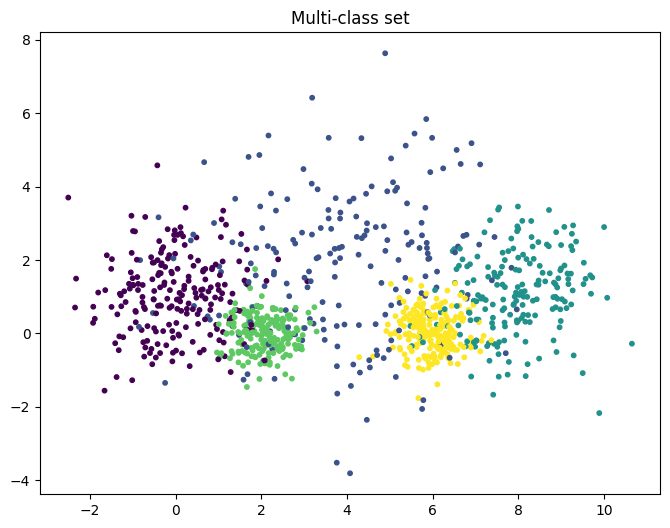

In [6]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title("Multi-class set")

Text(0.5, 1.0, 'Binary set')

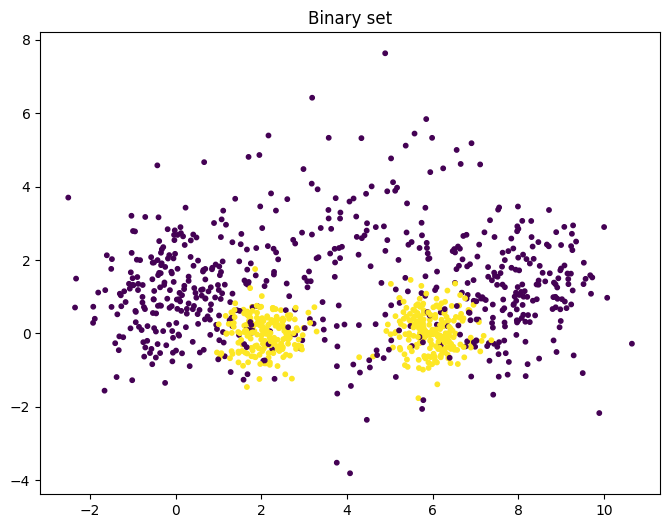

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title("Binary set")

# Part 1: Linear classifiers
### Linear regression

We see that even the binary set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression with the Mean Squared Error (MSE) loss, although it is not the most widely used approach for classification tasks: but we are interested. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [10]:
def add_bias(X, bias):
    """X is a NxM matrix: N datapoints, M features
    bias is a bias term, -1 or 1, or any other scalar. Use 0 for no bias
    Return a Nx(M+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1)) * bias # Make a N*1 matrix of biases
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [11]:
class NumpyClassifier():
    """Common methods to all Numpy classifiers --- if any"""

In [19]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, lr = 0.1, epochs=10):
        """X_train is a NxM matrix, N data points, M features
        t_train is a vector of length N,
        the target class values for the training data
        lr is our learning rate
        """
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, M) = X_train.shape
        
        self.weights = weights = np.zeros(M)
        
        for _ in range(epochs):
            # print("Epoch", epoch)
            weights -= lr / N *  X_train.T @ (X_train @ weights - t_train)      
    
    def predict(self, X, threshold=0.5):
        """X is a KxM matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.

In [25]:
def accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [84]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, lr=0.1, epochs=100)
print("Accuracy on the validation set:", accuracy(cl.predict(X_val), t2_val))

Accuracy on the validation set: 0.534


The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [111]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a prediction of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Classify each mesh point.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

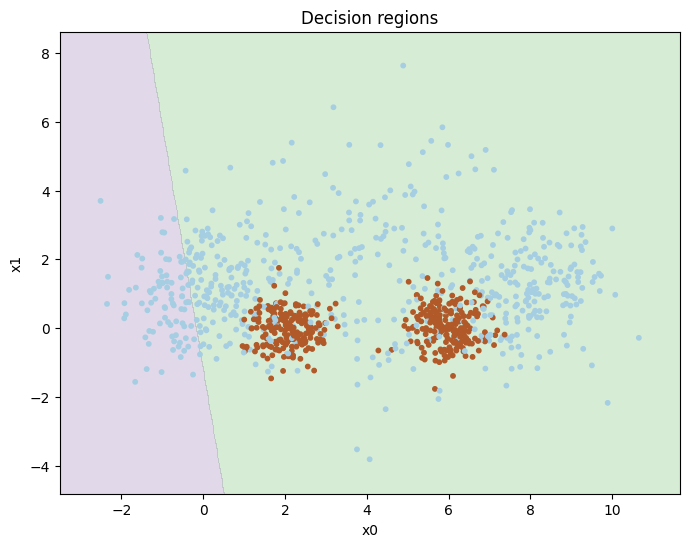

In [206]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, learning rate and the number of epochs, to get the best accuracy on the validation set. 

Report how the accuracy varies with the hyper-parameter settings. It it not sufficient to give the final hyperparameters. You must also show how you found then and results for alternative values you tried out.

When you are satisfied with the result, you may plot the decision boundaries, as above.

#### Solution

Here is the complete list of all tested hyper-parameters with the given accuracy:

| Learning Rate | Epochs | Accuracy |
|---------------|--------|----------|
| 0.1        | 10     | 54.2%    |
| 0.1        | 100     | 53.4%    |
| 0.1        | 1000     | 53.4%    |
| 0.01        | 10     | 47%    |
| 0.01        | 100     | 56.6%    |
| 0.01        | 1000     | 75%    |
| 0.03        | 1000     | 76%    |
| 0.02        | 2000     | 76%    |
| 0.002        | 2000     | 67.4%    |
| 0.002        | 10000     | 76%    |


I started by trying the same learning rate with different epochs. Increasing the amount of epochs did not improve the overall accuracy. This makes sense, because more iterations with same learning rate will just go over the global optima with the same step. Also, with very few epochs we do underfitting by not allowing the model to adjust enough. 

Decreasing the learning rate allows us to approach the local optima. It requires more epochs, but the performance are improved. The best accuracy was when I had was **76%**

Accuracy on the validation set: 0.76


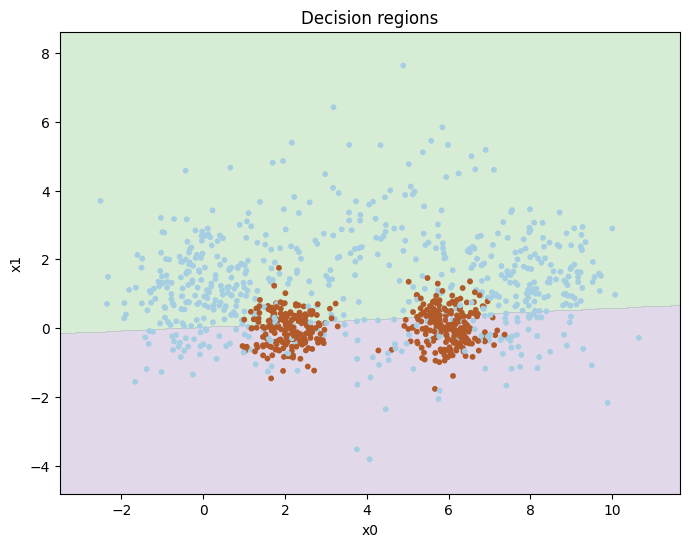

In [205]:
# Creating the model with parameters 
hyper_parameter_model = NumpyLinRegClass()
hyper_parameter_model.fit(X_train, t2_train, lr=0.03, epochs=1000)
print("Accuracy on the validation set:", accuracy(hyper_parameter_model.predict(X_val), t2_val))

# Plotting the decision boundary 
plot_decision_regions(X_train, t2_train, hyper_parameter_model)

### Task: Scaling

We have seen in the lectures that scaling the data may improve training speed and sometimes the performance. 

- Implement a scaler, at least the standard scaler (normalizer), but you can also try other techniques
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-parameter settings and show how you found them.

#### Solution


The following was tested:
| Learning Rate | Epochs | Accuracy |
|---------------|--------|----------|
| 0.1        | 10     | 54.2%    |



0.774

Accuracy on the validation set: 0.774


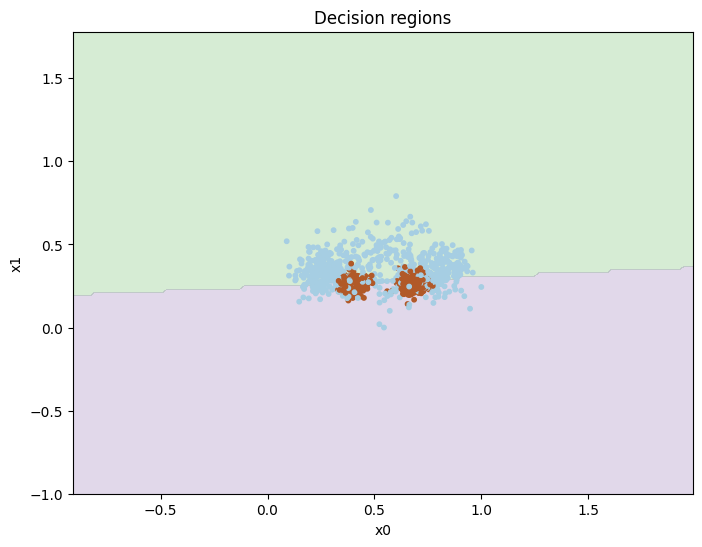

In [194]:
# Scaler function for normalizing the data
def scaler(data):
    data = (data - data.min()) / (data.max() - data.min())
    return data

# Scaling the training data
X_scaled = scaler(X_train)
t_scaled = scaler(t2_train)

# Create the model with scaled data 
scaled_model = NumpyLinRegClass()
scaled_model.fit(X_scaled, t_scaled, lr=0.446, epochs=1000)
print("Accuracy on the validation set:", accuracy(scaled_model.predict(X_val), t2_val))

# Plotting the decision boundary 
plot_decision_regions(X_scaled, t_scaled, scaled_model)


## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use the code from the solution to weekly exercise set week07.

b) In addition to the method `predict()` which predicts a class for the data, include a method `predict_probability()` which predict the probability of the data belonging to the positive class.

c) So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. The prefered loss for logistic regression is binary cross-entropy, but you can also try mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.
Also, calculate and store accuracies after each epoch.

d) In addition, extend the `fit()` method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to `fit()`, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the `fit()` method with two keyword arguments, `tol` (tolerance) and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs it was trained for.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding the optimal values. Also consider the effect of scaling the data.

g) After a succesful training, for your best model, plot both training loss and validation loss as functions of the number of epochs in one figure, and both training and validation accuracies as functions of the number of epochs in another figure. Comment on what you see. Are the curves monotone? Is this as expected?

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lectures how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

### Multinomial logistic regression
In the lectures, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier. (Don't expect a large difference on a simple task like this.)

Remember that this classifier uses softmax in the forward phase. For loss, it uses categorical cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

# Part 2: Multi-layer neural networks

## A first non-linear classifier

The following code is a simple implementation of a multi-layer perceptron or feed-forward neural network.
For now, it is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

The MLP class below misses the implementation of the `forward()` function. Your first task is to implement it. 

Remember that in the forward pass, we "feed" the input to the model, the model processes it and produces the output. The function should make use of the logistic activation function and bias.

In [ ]:
# First, we define the logistic function and its derivative:
def logistic(x):
    return 1/(1+np.exp(-x))

def logistic_diff(y):
    return y * (1 - y)

In [ ]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        # Dimensionality of the hidden layer
        self.dim_hidden = dim_hidden
        
        self.activ = logistic
        
        self.activ_diff = logistic_diff
        
    def forward(self, X):
        """TODO: 
        Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        
        raise NotImplementedError
        # return hidden_outs, outputs
    
    def fit(self, X_train, t_train, lr=0.001, epochs = 100):
        """Initialize the weights. Train *epochs* many epochs.
        
        X_train is a NxM matrix, N data points, M features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        lr is the learning rate
        """
        self.lr = lr
        
        # Turn t_train into a column vector, a N*1 matrix:
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Initialize the weights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        for e in range(epochs):
            # One epoch
            # The forward step:
            hidden_outs, outputs = self.forward(X_train_bias)
            # The delta term on the output node:
            out_deltas = (outputs - T_train)
            # The delta terms at the output of the hidden layer:
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The deltas at the input to the hidden layer:
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * 
                                self.activ_diff(hidden_outs[:, 1:]))  

            # Update the weights:
            self.weights2 -= self.lr * hidden_outs.T @ out_deltas
            self.weights1 -= self.lr * X_train_bias.T @ hiddenact_deltas 
            
    
    def predict(self, X):
        """Predict the class for the members of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)

When implemented, this model can be used to make a non-linear classifier for the set `(X, t2)`. Experiment with settings for learning rate and epochs and see how good results you can get. 
Report results for various settings. Be prepared to train for a long time (but you can control it via the number of epochs and hidden size). 

Plot the training set together with the decision regions as in Part I.

# Improving the MLP classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the `predict()` method, which predicts a class for the data, include the `predict_probability()` method which predict the probability of the data belonging to the positive class. The training should be based on these values, as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) Extend the `fit()` method with optional arguments for a validation set `(X_val, t_val)`. If a validation set is included in the call to `fit()`, calculate the loss and the accuracy for the validation set after each epoch.

d) Extend the `fit()` method with two keyword arguments, `tol` (tolerance) and `n_epochs_no_update` and stop training when the loss has not improved for more than `tol` after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Add an attribute to the classifier which tells us after fitting how many epochs it was trained on.

e) Tune the hyper-parameters: `lr`, `tol` and `dim-hidden` (size of the hidden layer).
Also, consider the effect of scaling the data.

f) After a succesful training with the best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both training and validation accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The MLP algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

## Multi-class neural network

The goal is to use a feed-forward neural network for non-linear multi-class classfication and apply it to the set `(X, t_multi)`.

Modify the network to become a multi-class classifier. As a sanity check of your implementation, you may apply it to `(X, t_2)` and see whether you get similar results as above.

Train the resulting classifier on `(X_train, t_multi_train)`, test it on `(X_val, t_multi_val)`, tune the hyper-parameters and report the accuracy.

Plot the decision boundaries for your best classifier.

# Part III: Final testing
We can now perform a final testing on the held-out test set we created in the beginning.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and evaluate on the held-out test set, but also on the validation set and the training set. Report the performance in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different dataset splits. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation and training data. Is this the case? 

Also report precision and recall for class 1.

## Multi-class task (X, t_multi)

Compare the three multi-class classifiers, the one-vs-rest and the multinomial logistic regression from part one and the multi-class neural network from part two. Evaluate on test, validation and training set as above.

Comment on the results.

Good luck!